In [2]:
!pwd

/content


In [3]:
!git clone https://github.com/dbecerril/afm-morphology-transfer-learning.git
%cd afm-morphology-transfer-learning
!pip install -r requirements.txt

Cloning into 'afm-morphology-transfer-learning'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 216 (delta 40), reused 199 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (216/216), 28.77 MiB | 24.70 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/afm-morphology-transfer-learning


In [ ]:
!python scripts/train_autoencoder.py --h5 /content/afm_patches.h5 --in-channels 2 --out-channels 1 --target-channel 0 --log-tb --log-dir logs --run-name test_run

Traceback (most recent call last):
  File "/content/afm-morphology-transfer-learning/scripts/train_autoencoder.py", line 43, in <module>
    from datasets.afm_h5_dataset import AFMPatchesH5Dataset, ChannelNorm
ModuleNotFoundError: No module named 'datasets'


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/

'/content/afm-morphology-transfer-learning'

In [2]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

from datasets.afm_h5_dataset import AFMPatchesH5Dataset
from model.autoencoder_model import AFMUNetAutoencoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
h5_path = "C:\\Users\\david\\OneDrive\\Documents\\ml_projects\\afm-morphology-transfer-learning\\datasets\\afm_patches_256.h5"
ckpt_path = "C:\\Users\\david\\OneDrive\\Documents\\ml_projects\\afm-morphology-transfer-learning\\checkpoints\\ae_best.pth"

# Dataset
# IMPORTANT: if patches/norm exists, do NOT apply ChannelNorm again
ds = AFMPatchesH5Dataset(
    h5_path,
    norm=None,                 # <-- correct for Option A
    aux_types=["PHASE", "FRICTION"],
    indices=None,
    x_dataset="patches/norm"   # <-- explicitly use normalized data
)

# Model (Option A)
model = AFMUNetAutoencoder(
    in_channels=1,                       # topo-only encoder input
    out_channels=1,       # should be 1 for topo recon
    aux_channels=1,
    aux_dropout= 0.3,
).to(device)

ck = torch.load(ckpt_path, map_location=device)
state = ck["model_state_dict"] if isinstance(ck, dict) else ck
model.load_state_dict(state)
model.eval()

def show_topo_recon(x, xhat, title=""):
    """
    x:    (1, C, H, W)   input  [topo, aux]
    xhat: (1, 1, H, W)   recon topo
    """
    # --- move to CPU + numpy ---
    x = x.detach().cpu().numpy()
    xhat = xhat.detach().cpu().numpy()

    topo_in = x[0, 0]     # (H, W)
    aux_in  = x[0, 1]     # (H, W)
    topo_out = xhat[0, 0] # (H, W)

    resid = np.abs(topo_in - topo_out)

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(topo_in, cmap="gray")
    axes[0].set_title("Topo input")
    axes[0].axis("off")

    axes[1].imshow(aux_in, cmap="gray")
    axes[1].set_title("Aux input (phase/friction)")
    axes[1].axis("off")

    axes[2].imshow(topo_out, cmap="gray")
    axes[2].set_title("Topo recon")
    axes[2].axis("off")

    im = axes[3].imshow(resid, cmap="inferno")
    axes[3].set_title("|Topo − Recon|")
    axes[3].axis("off")
    plt.colorbar(im, ax=axes[3])

    fig.suptitle(title)
    plt.show()


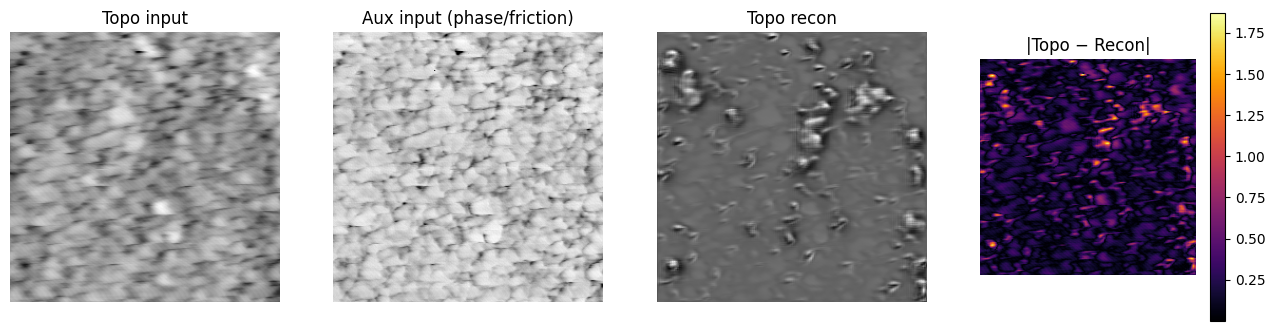

In [3]:
idx = 14
x = ds[idx].unsqueeze(0).to(device)  # (1, C, H, W)

topo = x[:, 0:1]   # ✅ (1, 1, H, W)
aux  = x[:, 1:2]   # ✅ (1, 1, H, W)

with torch.no_grad():
    xhat = model(topo, aux)
show_topo_recon(x, xhat, title="")

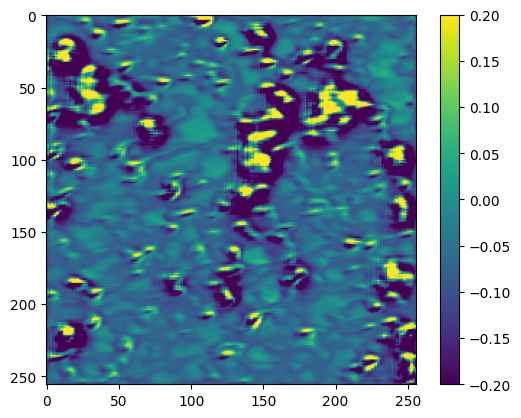

In [22]:
plt.imshow( xhat.squeeze().numpy(),vmax=0.2, vmin=-0.2 )
plt.colorbar()

In [ ]:
with torch.no_grad():
    xhat_aux = model(topo, aux)
    xhat_noaux = model(topo, torch.zeros_like(aux))
show_topo_recon(x, xhat_aux, title="with aux")
show_topo_recon(x, xhat_noaux, title="No aux")

# Load a data loader

In [15]:
from torch.utils.data import DataLoader
import json
import numpy as np
import torch

from datasets.afm_h5_dataset import AFMPatchesH5Dataset, ChannelNorm

#Load normalization stats
stats_path = "stats/channel_norm.json"  # or from run folder
with open(stats_path) as f:
    stats = json.load(f)

norm = ChannelNorm(
    mean=torch.tensor(stats["mean"], dtype=torch.float32),
    std=torch.tensor(stats["std"], dtype=torch.float32),
)

#load training indices
split_path = "splits/train.npy"  # adjust if needed
indices = np.load(split_path)

# Creat dataset
aux_types = ["TOPO", "PHASE"]  # ← example, MUST match training order

h5_path = "c:\\Users\\david\\OneDrive\\Documents\\ml_projects\\afm-morphology-transfer-learning\\datasets\\afm_patches_256.h5"

train_ds = AFMPatchesH5Dataset(
    h5_path,
    norm=norm,
    aux_types=aux_types,
    indices=indices,
)

train_loader = DataLoader(
    train_ds,
    batch_size=16,        # smaller is fine for inspection
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
    drop_last=False,
)

In [13]:
xb = next(iter(train_loader))
print(xb.shape)  # should be [B, C, H, W]


torch.Size([16, 2, 256, 256])


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

with torch.no_grad():
    xb = xb.to(device)
    yb = model(xb)

    per_ch_mse = ((yb - xb) ** 2).mean(dim=(0,2,3))
    per_ch_mae = (yb - xb).abs().mean(dim=(0,2,3))

print("Per-channel MSE:", per_ch_mse.cpu().numpy())
print("Per-channel MAE:", per_ch_mae.cpu().numpy())


NameError: name 'model' is not defined